In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

from IPython.display import clear_output
from sklearn.preprocessing import QuantileTransformer
from tensorflow.keras.optimizers import Adam
from stable_baselines3 import PPO, A2C

In [3]:
import sys
sys.path.append(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code")
from SL_evaluations import get_model, pnl_metric, sharpe_metric, pnl_curve
from RL_trading_envs import StockEnvTrainOnePerTime, get_actions

### Format data

In [4]:
df_full = pd.read_csv(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code\done_data.csv")
df_full = df_full.sort_values(['datadate','tic'])
df_full.loc[:, 'datadate'] = df_full['datadate'].astype(str)
df_full.reset_index(inplace = True, drop = True)
target = 'target_return'
df_full.loc[:, target] = df_full.groupby('tic')['adjcp'].apply(lambda x: x.pct_change().shift(-1)).fillna(0)

In [5]:
list_features = ['macd', 'rsi', 'cci', 'adx']
qt = QuantileTransformer(output_distribution = 'normal')
df_full.loc[:, list_features] = qt.fit_transform(df_full[list_features])

In [6]:
np.random.seed(1)
all_assets = df_full['tic'].unique().tolist()
all_dates = df_full['datadate'].unique().tolist()
list_assets  = np.random.choice(all_assets,
                                size = 15,
                                replace = False)
list_dates   = np.random.choice(all_dates,
                                size = 2000,
                                replace = False)
df = df_full.query("tic.isin(@list_assets) & datadate.isin(@list_dates)", engine = 'python')
df = df.sort_values(['datadate','tic'])
df.reset_index(inplace = True, drop = True)

In [7]:
df.shape

(30000, 14)

### Fit supervised learning

In [8]:
X = df[list_features].values
y = df[target].values * 100

In [9]:
fit_params = {'epochs': 1500, 'batch_size': 2048, 'verbose': 1}
optimizer_params = {'loss': 'mse', 'optimizer': Adam(learning_rate = 1e-3)}

In [10]:
_n_updates = df.shape[0]/fit_params['batch_size'] * fit_params['epochs']

In [11]:
%%time
model = get_model(n_inputs = len(list_features), n_outputs = 1, optimizer_params = optimizer_params)
model.fit(X, y, **fit_params)
yhat = model.predict(X).reshape(-1)

Epoch 1/1500
15/15 [==============================] - 0s 1ms/step - loss: 2.8028
Epoch 2/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.8033
Epoch 3/1500
15/15 [==============================] - 0s 1ms/step - loss: 2.8881
Epoch 4/1500
15/15 [==============================] - 0s 1ms/step - loss: 2.8223
Epoch 5/1500
15/15 [==============================] - 0s 3ms/step - loss: 2.7915
Epoch 6/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.7508
Epoch 7/1500
15/15 [==============================] - 0s 1ms/step - loss: 2.7595
Epoch 8/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.8360
Epoch 9/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.9591
Epoch 10/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.8187
Epoch 11/1500
15/15 [==============================] - 0s 1ms/step - loss: 2.9036
Epoch 12/1500
15/15 [==============================] - 0s 2ms/step - loss: 2.8608
Epoch 13/1500
15/15 [====

In [14]:
pnl_metric(y, yhat > 0)

0.1584409094813589

### Fit reinforcement learning

In [15]:
_n_updates

21972.65625

In [16]:
_n_updates / (2048/64 * 10)

68.66455078125

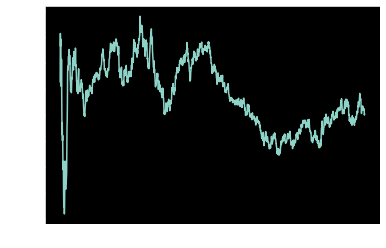

Wall time: 7h 14min 27s


In [26]:
%%time
agent_parameters = dict(learning_rate=0.0003,
                        n_steps=2048,
                        batch_size=64,
                        n_epochs=10)
# agent_parameters = dict(learning_rate=0.0003,
#                         n_steps=2048,
#                         batch_size=2048,
#                         n_epochs=1)
env   = StockEnvTrainOnePerTime(df, list_features)
model = PPO('MlpPolicy', env, verbose=0, **agent_parameters)
list_results = []
for _ in range(1600):
    clear_output(wait=True)
    model.learn(total_timesteps=1e4)
    yhat = get_actions(df, list_features, model).reshape(-1)
    list_results.append(pnl_metric(y, yhat)/0.15844)
    plt.plot(list_results)
    plt.show()

(array([ 1471.,   604.,   973.,   866.,   734.,   743.,   972.,  1146.,
         1311., 21180.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

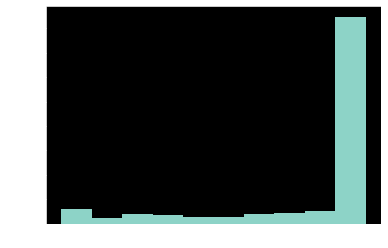

In [28]:
plt.hist(yhat)

In [20]:
%matplotlib inline

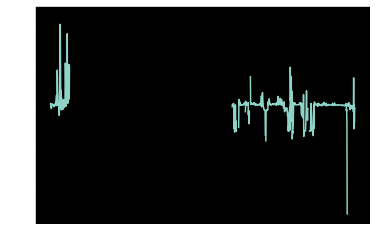

In [ ]:
%%time
agent_parameters = dict(learning_rate=0.0003,
                        n_steps=2048,
                        batch_size=64,
                        n_epochs=10)
# agent_parameters = dict(learning_rate=0.0003,
#                         n_steps=2048,
#                         batch_size=2048,
#                         n_epochs=1)
env   = StockEnvTrainOnePerTime(df, list_features)
model = A2C('MlpPolicy', env, verbose=0)
list_results = []
for _ in range(1600):
    clear_output(wait=True)
    model.learn(total_timesteps=1e4)
    yhat = get_actions(df, list_features, model).reshape(-1)
    list_results.append(pnl_metric(y, yhat)/0.15844)
    plt.plot(list_results)
    plt.show()

In [ ]:
plt.hist(yhat)